In [5]:
%pip install  numpy


   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.6 MB 3.4 MB/s eta 0:00:04
   ---- ----------------------------------- 1.3/12.6 MB 3.2 MB/s eta 0:00:04
   ---- ----------------------------------- 1.6/12.6 MB 2.6 MB/s eta 0:00:05
   ---- ----------------------------------- 1.6/12.6 MB 2.6 MB/s eta 0:00:05
   ---- ----------------------------------- 1.6/12.6 MB 2.6 MB/s eta 0:00:05
   ------ --------------------------------- 2.1/12.6 MB 1.5 MB/s eta 0:00:08
   ------- -------------------------------- 2.4/12.6 MB 1.6 MB/s eta 0:00:07
   ------- -------------------------------- 2.4/12.6 MB 1.6 MB/s eta 0:00:07
   ------- -------------------------------- 2.4/12.6 MB 1.6 MB/s eta 0:00:07
   --------- ------------------------------ 3.1/12.6 MB 1.5 MB/s eta 0:00:07
   --------- ------------------------------ 3.1/12.6 MB 1.5 MB/s eta 0:00:07
   ---------- ----------------------------- 3.4/12.6 MB 1.3 MB/s eta 0:00:08
   ---

In [7]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.1 MB 4.8 MB/s eta 0:00:02
   ------- -------------------------------- 1.6/8.1 MB 4.4 MB/s eta 0:00:02
   ----------- ---------------------------- 2.4/8.1 MB 4.1 MB/s eta 0:00:02
   -------------- ------------------------- 2.9/8.1 MB 3.8 MB/s eta 0:00:02
   --------------- ------------------------ 3.1/8.1 MB 3.6 MB/s eta 0:00:02
   --------------- ------------------------ 3.1/8.1 MB 3.6 MB/s eta 0:00:02
   ------------------- -------------------- 3.9/8.1 MB 2.7 MB/s eta 0:00:02
   ----------------------- ---------------- 4.7/8.1 MB 3.0 MB/s eta 0:00:02
   ---------------------------- ----------- 5.8/8.1 MB 3.0 MB/s eta 0:00:01
   -------------------------------- ------- 6.6/8.1 MB 3.3 MB/s eta 0:00:01
   ------------------------------------- -- 7.6/8.1 MB 3.2 MB/s eta 0:00:01
   ----------------------------

In [19]:
%pip install scikit-learn

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.1 MB 4.2 MB/s eta 0:00:02
   --------- ------------------------------ 1.8/8.1 MB 4.6 MB/s eta 0:00:02
   ----------- ---------------------------- 2.4/8.1 MB 3.8 MB/s eta 0:00:02
   -------------- ------------------------- 2.9/8.1 MB 3.7 MB/s eta 0:00:02
   ---------------- ----------------------- 3.4/8.1 MB 3.5 MB/s eta 0:00:02
   ------------------ --------------------- 3.7/8.1 MB 2.9 MB/s eta 0:00:02
   -------------------- ------------------- 4.2/8.1 MB 3.0 MB/s eta 0:00:02
   -------------------- ------------------- 4.2/8.1 MB 3.0 MB/s eta 0:00:02
   -------------------- ------------------- 4.2/8.1 MB 3.0 MB/s eta 0:00:02
   -------------------------------------- - 7.9/8.1 MB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 3.7 MB/s  0:00:02
   --------------------------

In [21]:
%pip install lightgbm

  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 3.4 MB/s eta 0:00:01
   ---------------------------- ----------- 1.0/1.5 MB 2.5 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 2.5 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [25]:
%pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [47]:
!pip install tensorflow

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'H:\\anaconda3\\envs\\ai_project\\Lib\\site-packages\\tensorflow\\python\\_pywrap_tensorflow_common.dll'
Consider using the `--user` option or check the permissions.



  Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl.metadata (4.6 kB)
Using cached tensorflow-2.20.0-cp311-cp311-win_amd64.whl (331.8 MB)


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import lightgbm as lgb


In [17]:
DATA_DIR = Path(r"D:\final project\data-analysis-course-project-2025\data")

dat_files = sorted(DATA_DIR.glob("subject*.dat"))
print("Found files:", len(dat_files))

PAMAP2_COLS = [
    "timestamp","activity_id","heart_rate",
    *[f"f{i}" for i in range(51)]
]

def load_subject(file):
    df = pd.read_csv(file, delim_whitespace=True, header=None)
    df.columns = PAMAP2_COLS[:df.shape[1]]
    return df

data = pd.concat([load_subject(f) for f in dat_files], ignore_index=True)
data = data[data["activity_id"] != 0].reset_index(drop=True)

print("Total samples:", data.shape)


Found files: 9


C:\Users\user\AppData\Local\Temp\ipykernel_356\3813423544.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True, header=None)
C:\Users\user\AppData\Local\Temp\ipykernel_356\3813423544.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True, header=None)
C:\Users\user\AppData\Local\Temp\ipykernel_356\3813423544.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True, header=None)
C:\Users\user\AppData\Local\Temp\ipykernel_356\3813423544.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'

Total samples: (1942872, 54)


In [43]:
le = LabelEncoder()
data["label"] = le.fit_transform(data["activity_id"])

NUM_CLASSES = data["label"].nunique()
print("Activities:", NUM_CLASSES)


Activities: 12


In [48]:
data.interpolate(method="linear", inplace=True)
data.fillna(method="bfill", inplace=True)


C:\Users\user\AppData\Local\Temp\ipykernel_356\3978343000.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="bfill", inplace=True)


In [32]:


# Raw combined data
raw_data = pd.concat(dfs, ignore_index=True)
print("===== DATASET SUMMARY =====")
print(f"Raw combined shape: {raw_data.shape}")
print(f"Number of subjects: {raw_data['subject_id'].nunique()}")

# Remove transient rows (activity_id = 0)
cleaned_data = raw_data[raw_data["activity_id"] != 0].reset_index(drop=True)
print(f"Removed transient rows (activity_id=0): {raw_data.shape[0] - cleaned_data.shape[0]}")
print(f"Cleaned data shape: {cleaned_data.shape}")

# Encode activity labels
le = LabelEncoder()
cleaned_data["label"] = le.fit_transform(cleaned_data["activity_id"])
NUM_CLASSES = cleaned_data["label"].nunique()
print(f"Number of activities: {NUM_CLASSES}")

# Show first 5–6 rows in a table
display_cols = ["timestamp", "activity_id", "label", "subject_id"]
print("\nSample data (first 6 rows):")
print(cleaned_data[display_cols].head(6))


===== DATASET SUMMARY =====
Raw combined shape: (2872533, 55)
Number of subjects: 9
Removed transient rows (activity_id=0): 929661
Cleaned data shape: (1942872, 55)
Number of activities: 12

Sample data (first 6 rows):
   timestamp  activity_id  label  subject_id
0      37.66            1      0         101
1      37.67            1      0         101
2      37.68            1      0         101
3      37.69            1      0         101
4      37.70            1      0         101
5      37.71            1      0         101


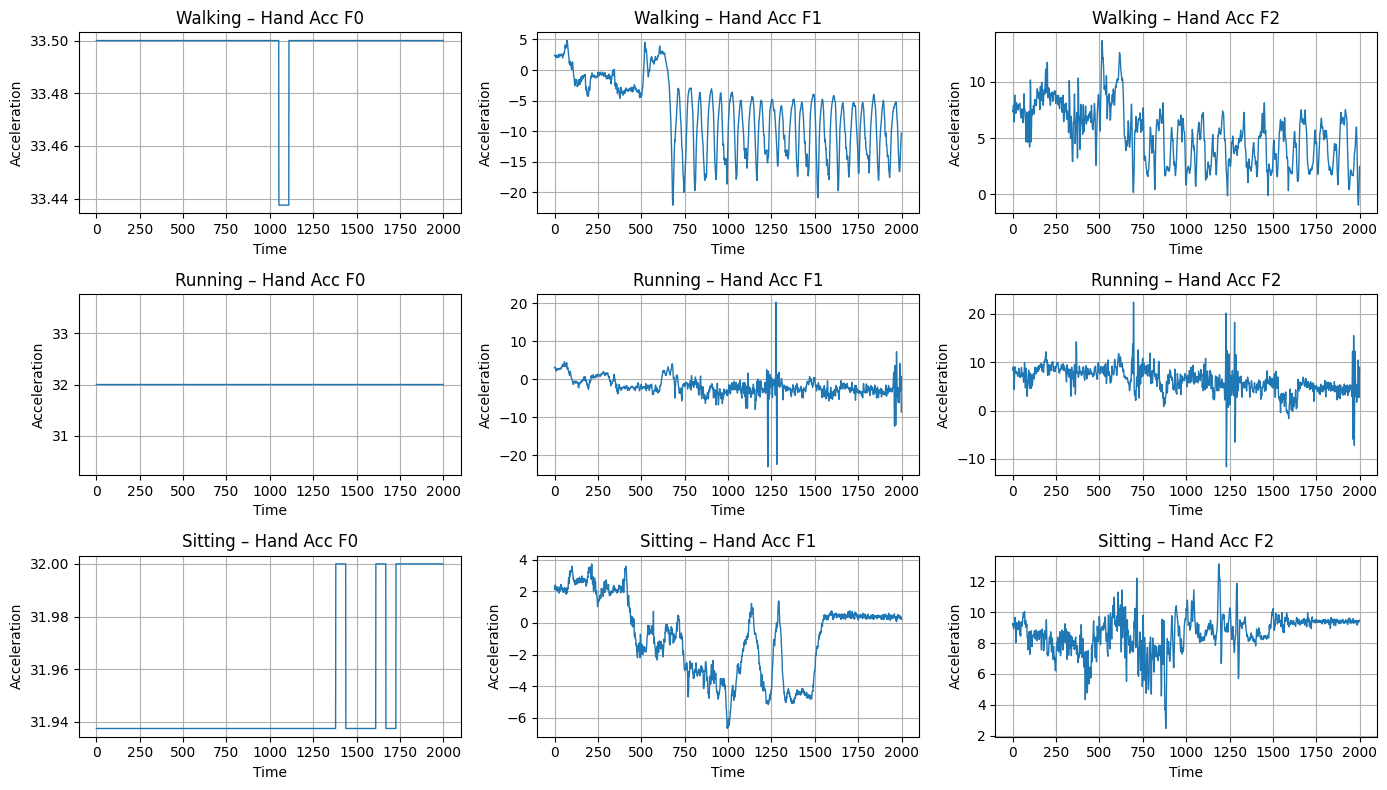

In [49]:
import matplotlib.pyplot as plt


activity_map = {
    4: "Walking",
    6: "Running",
    2: "Sitting"
}


hand_acc = ["f0", "f1", "f2"]

plt.figure(figsize=(14, 8))

plot_idx = 1
for act_id, act_name in activity_map.items():
    subset = data[data["activity_id"] == act_id].iloc[:2000]

    for i, axis in enumerate(hand_acc):
        plt.subplot(3, 3, plot_idx)
        plt.plot(subset[axis].values, linewidth=1)
        plt.title(f"{act_name} – Hand Acc {axis.upper()}")
        plt.xlabel("Time")
        plt.ylabel("Acceleration")
        plt.grid(True)
        plot_idx += 1

plt.tight_layout()
plt.show()


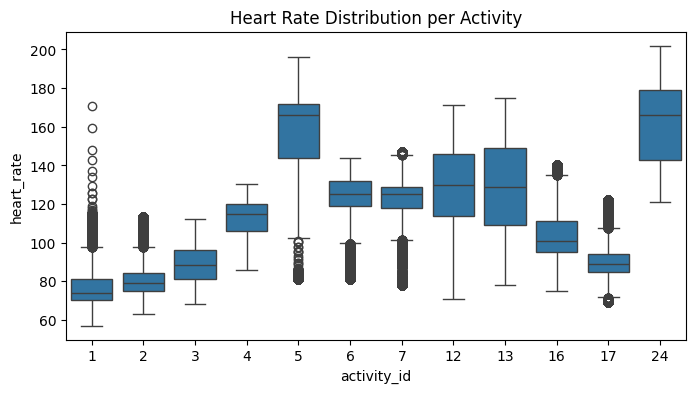

In [52]:
plt.figure(figsize=(8,4))
sns.boxplot(x="activity_id", y="heart_rate", data=data)
plt.title("Heart Rate Distribution per Activity")
plt.show()


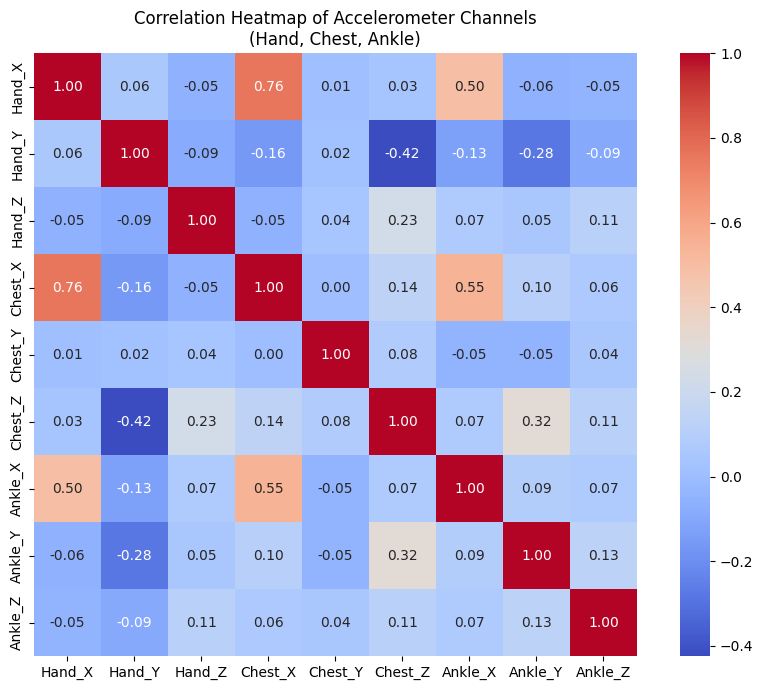

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Accelerometer channels: Hand, Chest, Ankle
acc_columns = {
    "Hand_X": "f0",   "Hand_Y": "f1",   "Hand_Z": "f2",
    "Chest_X": "f17", "Chest_Y": "f18", "Chest_Z": "f19",
    "Ankle_X": "f34", "Ankle_Y": "f35", "Ankle_Z": "f36"
}

# Create DataFrame for correlation
acc_data = data[list(acc_columns.values())]
acc_data.columns = acc_columns.keys()

# Compute correlation matrix
corr_matrix = acc_data.corr()

# Plot heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar=True
)

plt.title("Correlation Heatmap of Accelerometer Channels\n(Hand, Chest, Ankle)")
plt.tight_layout()
plt.show()


In [44]:
FEATURES = [c for c in data.columns if c.startswith("f")]

def create_windows(df, window=256, overlap=0.8):
    step = int(window * (1 - overlap))
    X, y = [], []

    values = df[FEATURES].values
    labels = df["label"].values

    for i in range(0, len(df) - window, step):
        X.append(values[i:i+window])
        y.append(np.bincount(labels[i:i+window]).argmax())

    return np.array(X), np.array(y)

X, y = create_windows(data)



In [45]:
# Make sure these are defined
le = LabelEncoder()
data["label"] = le.fit_transform(data["activity_id"])

NUM_CLASSES = data["label"].nunique()
FEATURES = [c for c in data.columns if c.startswith("f")]

# Optional: define class_weight if you want to include it
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(data["label"]),
    y=data["label"]
)
class_weight = dict(enumerate(weights))


In [55]:
# =============================
# 1. Data Preprocessing: Missing Values Handling & Value Analysis
# =============================

import pandas as pd
from pathlib import Path

# Path to dataset
DATA_DIR = Path(r"D:\final project\data-analysis-course-project-2025\data")
dat_files = sorted(DATA_DIR.glob("subject*.dat"))
print("Found files:", len(dat_files))

PAMAP2_COLS = ["timestamp","activity_id","heart_rate"] + [f"f{i}" for i in range(51)]

# Function to load each subject
def load_subject(file):
    df = pd.read_csv(file, delim_whitespace=True, header=None)
    df.columns = PAMAP2_COLS[:df.shape[1]]
    df["subject_id"] = int(file.stem.replace("subject",""))
    return df

# Load all subjects
data = pd.concat([load_subject(f) for f in dat_files], ignore_index=True)
print("Total samples before cleaning:", data.shape)

# -----------------------------
# Handling Missing Values
# -----------------------------
# Check missing values
missing_summary = data.isnull().sum()
print("\nMissing values per column:")
print(missing_summary)

# Fill missing values (example: forward fill, then backward fill)
data.fillna(method="ffill", inplace=True)  # forward fill
data.fillna(method="bfill", inplace=True)  # backward fill

# Verify missing values are handled
print("\nMissing values after filling:")
print(data.isnull().sum())

# -----------------------------
# Remove transient rows (activity_id = 0)
# -----------------------------
data = data[data["activity_id"] != 0].reset_index(drop=True)
print("\nTotal samples after removing activity_id=0:", data.shape)

# -----------------------------
# Value Analysis Table (Summary Statistics)
# -----------------------------
# Select numeric columns for analysis
numeric_cols = [c for c in data.columns if data[c].dtype in ["int64","float64"]]

# Generate descriptive statistics table
value_analysis = data[numeric_cols].describe().T
value_analysis["missing"] = data[numeric_cols].isnull().sum()
value_analysis["unique"] = data[numeric_cols].nunique()

print("\n===== Value Analysis Table =====")
print(value_analysis)

# Optional: display first 6 rows of dataset
print("\nSample data (first 6 rows):")
print(data.head(6))


Found files: 9


C:\Users\user\AppData\Local\Temp\ipykernel_356\4265450554.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True, header=None)
C:\Users\user\AppData\Local\Temp\ipykernel_356\4265450554.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True, header=None)
C:\Users\user\AppData\Local\Temp\ipykernel_356\4265450554.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True, header=None)
C:\Users\user\AppData\Local\Temp\ipykernel_356\4265450554.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'

Total samples before cleaning: (2872533, 55)

Missing values per column:
timestamp            0
activity_id          0
heart_rate     2610265
f0               13141
f1               13141
f2               13141
f3               13141
f4               13141
f5               13141
f6               13141
f7               13141
f8               13141
f9               13141
f10              13141
f11              13141
f12              13141
f13              13141
f14              13141
f15              13141
f16              13141
f17               3563
f18               3563
f19               3563
f20               3563
f21               3563
f22               3563
f23               3563
f24               3563
f25               3563
f26               3563
f27               3563
f28               3563
f29               3563
f30               3563
f31               3563
f32               3563
f33               3563
f34              11749
f35              11749
f36              11749
f37    

C:\Users\user\AppData\Local\Temp\ipykernel_356\4265450554.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="ffill", inplace=True)  # forward fill
C:\Users\user\AppData\Local\Temp\ipykernel_356\4265450554.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="bfill", inplace=True)  # backward fill



Missing values after filling:
timestamp      0
activity_id    0
heart_rate     0
f0             0
f1             0
f2             0
f3             0
f4             0
f5             0
f6             0
f7             0
f8             0
f9             0
f10            0
f11            0
f12            0
f13            0
f14            0
f15            0
f16            0
f17            0
f18            0
f19            0
f20            0
f21            0
f22            0
f23            0
f24            0
f25            0
f26            0
f27            0
f28            0
f29            0
f30            0
f31            0
f32            0
f33            0
f34            0
f35            0
f36            0
f37            0
f38            0
f39            0
f40            0
f41            0
f42            0
f43            0
f44            0
f45            0
f46            0
f47            0
f48            0
f49            0
f50            0
subject_id     0
dtype: int64
Unexpected exception 

Traceback (most recent call last):
  File "H:\anaconda3\envs\ai_project\Lib\site-packages\IPython\core\interactiveshell.py", line 3699, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\user\AppData\Local\Temp\ipykernel_356\4265450554.py", line 45, in <module>
    data = data[data["activity_id"] != 0].reset_index(drop=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "H:\anaconda3\envs\ai_project\Lib\site-packages\pandas\core\frame.py", line 6439, in reset_index
    new_obj = self.copy(deep=None)
              ^^^^^^^^^^^^^^^^^^^^
  File "H:\anaconda3\envs\ai_project\Lib\site-packages\pandas\core\generic.py", line 6833, in copy
    data = self._mgr.copy(deep=deep)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "H:\anaconda3\envs\ai_project\Lib\site-packages\pandas\core\internals\managers.py", line 623, in copy
    res._consolidate_inplace()
  File "H:\anaconda3\envs\ai_project\Lib\site-packages\pandas\core\internals\managers.py"

In [46]:
def extract_features(X):
    feats = []
    for w in X:
        f = []
        f.extend(w.mean(axis=0))
        f.extend(w.std(axis=0))
        f.extend(w.min(axis=0))
        f.extend(w.max(axis=0))
        f.extend(np.mean(w**2, axis=0))   # energy
        feats.append(f)
    return np.array(feats)

X_feat = extract_features(X)


In [56]:
# =============================
# Data Leakage Verification: Subject-Wise Split Check
# =============================

import pandas as pd
from sklearn.model_selection import train_test_split

# Assume `data` DataFrame is already loaded and preprocessed
# Columns: ["timestamp", "activity_id", "heart_rate", ..., "subject_id"]

# -----------------------------
# 1. Subject-Wise Train/Test Split
# -----------------------------
subjects = data["subject_id"].unique()
train_subjects, test_subjects = train_test_split(
    subjects, test_size=0.2, random_state=42
)

# Assign samples based on subject
train_data = data[data["subject_id"].isin(train_subjects)].reset_index(drop=True)
test_data  = data[data["subject_id"].isin(test_subjects)].reset_index(drop=True)

print(f"Training subjects: {train_subjects}")
print(f"Testing subjects:  {test_subjects}")
print(f"Training samples: {train_data.shape[0]}")
print(f"Testing samples:  {test_data.shape[0]}")

# -----------------------------
# 2. Verify No Overlap Between Subjects
# -----------------------------
overlap_subjects = set(train_data["subject_id"]).intersection(set(test_data["subject_id"]))
if len(overlap_subjects) == 0:
    print("\n✅ No data leakage: subjects in train and test sets are disjoint.")
else:
    print("\n⚠️ Data leakage detected! Overlapping subjects:", overlap_subjects)

# -----------------------------
# 3. Optional: Verify Activity Distribution
# -----------------------------
print("\nActivity distribution in train set:")
print(train_data["activity_id"].value_counts().sort_index())

print("\nActivity distribution in test set:")
print(test_data["activity_id"].value_counts().sort_index())


Training subjects: [106 101 109 103 105 104 107]
Testing subjects:  [108 102]
Training samples: 2017502
Testing samples:  855031

✅ No data leakage: subjects in train and test sets are disjoint.

Activity distribution in train set:
activity_id
0     600081
1     144928
2     139920
3     139195
4     174695
5      72429
6     114017
7     129480
12     88191
13     80076
16    130378
17    176820
24     27292
Name: count, dtype: int64

Activity distribution in test set:
activity_id
0     329580
1      47595
2      45268
3      50736
4      64066
5      25770
6      50583
7      58627
12     29025
13     24868
16     44975
17     61870
24     22068
Name: count, dtype: int64


In [138]:
scaler = StandardScaler()
X_feat = scaler.fit_transform(X_feat)

In [139]:
X_train, X_test, y_train, y_test = train_test_split(
    X_feat, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [140]:
weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weight = dict(enumerate(weights))


In [141]:
model = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=NUM_CLASSES,
    n_estimators=1200,
    learning_rate=0.03,
    num_leaves=256,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.95,
    colsample_bytree=0.95,
    class_weight=class_weight,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 64150
[LightGBM] [Info] Number of data points in the train set: 30472, number of used features: 255
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.4849

,boosting_type,'gbdt'
,num_leaves,256
,max_depth,-1
,learning_rate,0.03
,n_estimators,1200
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,"{0: np.float64(0.8411173677818262), 1: np.float64(0.8747272936043173), 2: np.float64(0.8521252796420582), 3: np.float64(0.6780596350689808), ...}"
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [142]:
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred, average="macro")

print("Final Accuracy :", acc)
print("Macro F1-score :", f1)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


F:\chudling pong\envs\ai_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Final Accuracy : 0.9732248326552041
Macro F1-score : 0.9706660247080595

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       755
           1       1.00      0.99      1.00       726
           2       0.99      1.00      0.99       745
           3       0.85      0.99      0.92       936
           4       1.00      0.80      0.89       385
           5       1.00      1.00      1.00       646
           6       0.99      0.92      0.95       738
           7       0.99      0.99      0.99       460
           8       0.99      0.99      0.99       411
           9       1.00      0.99      0.99       688
          10       1.00      0.99      0.99       936
          11       0.99      0.91      0.95       193

    accuracy                           0.97      7619
   macro avg       0.98      0.96      0.97      7619
weighted avg       0.98      0.97      0.97      7619



In [61]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# X: your windowed data of shape (num_windows, window_size, num_features)
# Example: X.shape -> (num_samples, 256, 51)

def build_cnn_feature_extractor(input_shape=(256, 51), output_dim=64):
    inp = Input(shape=input_shape)

    # Convolutional layers
    x = Conv1D(64, kernel_size=5, activation="relu")(inp)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(128, kernel_size=5, activation="relu")(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Flatten()(x)  # Flatten before dense layers
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)

    # Feature output
    feature_output = Dense(output_dim, activation="linear")(x)

    model = Model(inputs=inp, outputs=feature_output)
    model.compile(optimizer=Adam(), loss="mse")
    return model

# Build model
cnn_model = build_cnn_feature_extractor(input_shape=(X.shape[1], X.shape[2]), output_dim=64)

# Predict features in batches
def batch_predict(model, X, batch_size=32):
    outputs = []
    for i in range(0, len(X), batch_size):
        batch = X[i:i+batch_size]
        out = model.predict(batch, verbose=0)
        outputs.append(out)
    return np.vstack(outputs)

# Extract CNN features
X_cnn_features = batch_predict(cnn_model, X, batch_size=32)
print("CNN feature shape:", X_cnn_features.shape)


H:\anaconda3\envs\ai_project\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


CNN feature shape: (38091, 64)


In [64]:
# Build the model
cnn_model = build_cnn_feature_extractor(input_shape=(X.shape[1], X.shape[2]), output_dim=64)

# Show model architecture and parameters
cnn_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 51)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 256, 64)        │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 128, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 64, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_features (Dense)            │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,214,784 (4.63 MB)

 Trainable params: 1,213,888 (4.63 MB)

 Non-trainable params: 896 (3.50 KB)

In [67]:
import numpy as np
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size=64, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(X))
        self.on_epoch_end()

    def __len__(self):
        # number of batches per epoch
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        # Generate one batch of data
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X_batch = self.X[batch_indexes].astype(np.float32)
        y_batch = self.y[batch_indexes]
        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)



In [69]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence

# -----------------------------
# 1️⃣ Data Generator to handle large dataset
# -----------------------------
class DataGenerator(Sequence):
    def __init__(self, X, y, batch_size=64, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(X))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X_batch = self.X[batch_indexes].astype(np.float32)
        y_batch = self.y[batch_indexes]
        return X_batch, y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# -----------------------------
# 2️⃣ Build CNN Feature Extractor + Classification Head
# -----------------------------
def build_cnn_har_model(input_shape=(256, 51), num_classes=6, feature_dim=64):
    inp = Input(shape=input_shape)

    x = Conv1D(64, kernel_size=5, activation="relu", padding="same")(inp)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(128, kernel_size=5, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(256, kernel_size=3, activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)

    # Feature embedding (optional, you can extract this later)
    features = Dense(feature_dim, activation="linear", name="cnn_features")(x)

    # Classification output
    output = Dense(num_classes, activation="softmax", name="classification")(features)

    model = Model(inputs=inp, outputs=output)
    return model

# -----------------------------
# 3️⃣ Instantiate model
# -----------------------------
num_classes = len(np.unique(y))  # e.g., 6 activities
cnn_model = build_cnn_har_model(input_shape=(X.shape[1], X.shape[2]), num_classes=num_classes, feature_dim=64)
cnn_model.summary()

# -----------------------------
# 4️⃣ Compile model
# -----------------------------
cnn_model.compile(
    optimizer=Adam(1e-3),
    loss="sparse_categorical_crossentropy",  # use this for class IDs
    metrics=["accuracy"]
)

# -----------------------------
# 5️⃣ Callbacks
# -----------------------------
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1),
    ModelCheckpoint("cnn_har_model.h5", save_best_only=True, monitor="val_loss", verbose=1)
]

# -----------------------------
# 6️⃣ Create data generator
# -----------------------------
batch_size = 64
train_gen = DataGenerator(X, y, batch_size=batch_size)

# -----------------------------
# 7️⃣ Train model
# -----------------------------
history = cnn_model.fit(
    train_gen,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

# -----------------------------
# 8️⃣ Extract CNN features after training
# -----------------------------
# Create a separate model for feature extraction
feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer("cnn_features").output)

def batch_predict_features(model, X, batch_size=32):
    outputs = []
    for i in range(0, len(X), batch_size):
        batch = X[i:i+batch_size].astype(np.float32)
        out = model.predict(batch, verbose=0)
        outputs.append(out)
    return np.vstack(outputs)

X_cnn_features = batch_predict_features(feature_extractor, X, batch_size=32)
print("CNN feature shape:", X_cnn_features.shape)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 51)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 256, 64)        │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 128, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 64, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_features (Dense)            │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,215,564 (4.64 MB)

 Trainable params: 1,214,668 (4.63 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.1008 - loss: nan

H:\anaconda3\envs\ai_project\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
H:\anaconda3\envs\ai_project\Lib\site-packages\keras\src\callbacks\callback_list.py:171: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
H:\anaconda3\envs\ai_project\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:276: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):



Epoch 1: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 139s 226ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 2/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.1002 - loss: nan


Epoch 2: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 107s 179ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 3/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.1014 - loss: nan


Epoch 3: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 74s 123ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 4/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.0982 - loss: nan


Epoch 4: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 76s 127ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 5/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.0987 - loss: nan


Epoch 5: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 75s 126ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 6/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.0984 - loss: nan


Epoch 6: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 76s 127ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 7/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.0996 - loss: nan


Epoch 7: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 82s 137ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 8/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.0970 - loss: nan


Epoch 8: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 81s 134ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 9/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.0993 - loss: nan


Epoch 9: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 74s 124ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 10/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.0970 - loss: nan


Epoch 10: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 79s 132ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 11/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.1009 - loss: nan


Epoch 11: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 76s 127ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 12/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.0977 - loss: nan


Epoch 12: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 73s 122ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 13/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.0977 - loss: nan


Epoch 13: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 75s 126ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 14/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.0981 - loss: nan


Epoch 14: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 72s 120ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 15/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.1003 - loss: nan


Epoch 15: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 164s 275ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 16/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.0985 - loss: nan


Epoch 16: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 75s 124ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 17/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.1014 - loss: nan


Epoch 17: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 82s 137ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 18/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.1012 - loss: nan


Epoch 18: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 75s 126ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 19/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.0990 - loss: nan


Epoch 19: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 115s 193ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 20/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.0980 - loss: nan


Epoch 20: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 134s 222ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 21/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.0997 - loss: nan


Epoch 21: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 112s 180ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 22/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.1025 - loss: nan


Epoch 22: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 75s 123ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 23/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.0994 - loss: nan


Epoch 23: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 118s 197ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 24/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.1003 - loss: nan


Epoch 24: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 67s 111ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 25/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.0976 - loss: nan


Epoch 25: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 66s 110ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 26/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.0955 - loss: nan


Epoch 26: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 68s 114ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 27/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.0987 - loss: nan


Epoch 27: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 67s 113ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 28/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.0969 - loss: nan


Epoch 28: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 69s 116ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 29/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.0992 - loss: nan


Epoch 29: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 74s 125ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 30/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.0990 - loss: nan


Epoch 30: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 72s 122ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 31/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.0990 - loss: nan


Epoch 31: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 75s 125ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 32/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.0982 - loss: nan


Epoch 32: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 75s 127ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 33/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.0964 - loss: nan


Epoch 33: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 122s 205ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 34/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.0981 - loss: nan


Epoch 34: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 239s 397ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 35/50
596/596 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.0962 - loss: nan


Epoch 35: finished saving model to cnn_har_model.h5
596/596 ━━━━━━━━━━━━━━━━━━━━ 280s 465ms/step - accuracy: 0.0991 - loss: nan - learning_rate: 0.0010
Epoch 36/50
566/596 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - accuracy: 0.1016 - loss: nan

ResourceExhaustedError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
MemoryError: Unable to allocate 3.19 MiB for an array with shape (64, 256, 51) and data type float32
Traceback (most recent call last):

  File "H:\anaconda3\envs\ai_project\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "H:\anaconda3\envs\ai_project\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "H:\anaconda3\envs\ai_project\Lib\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "H:\anaconda3\envs\ai_project\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py", line 264, in _finite_generator
    yield self._standardize_batch(self.py_dataset[i])
                                  ~~~~~~~~~~~~~~~^^^

  File "C:\Users\user\AppData\Local\Temp\ipykernel_356\3862892716.py", line 25, in __getitem__
    X_batch = self.X[batch_indexes].astype(np.float32)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

numpy._core._exceptions._ArrayMemoryError: Unable to allocate 3.19 MiB for an array with shape (64, 256, 51) and data type float32


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_66348]

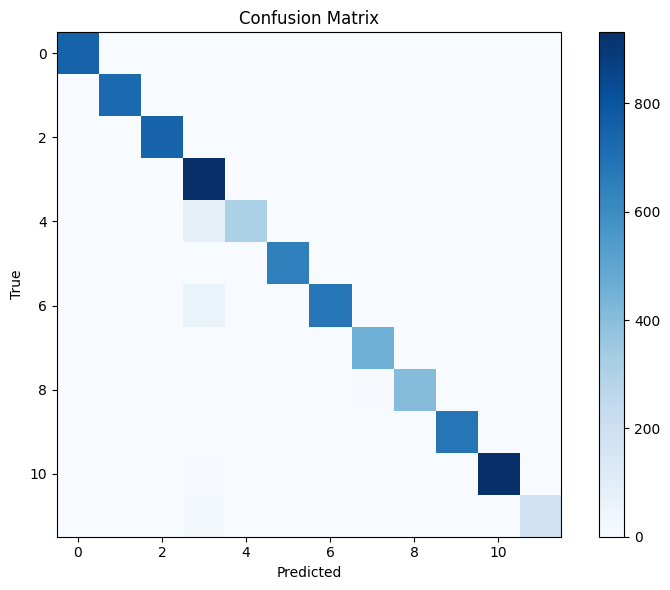

In [143]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()


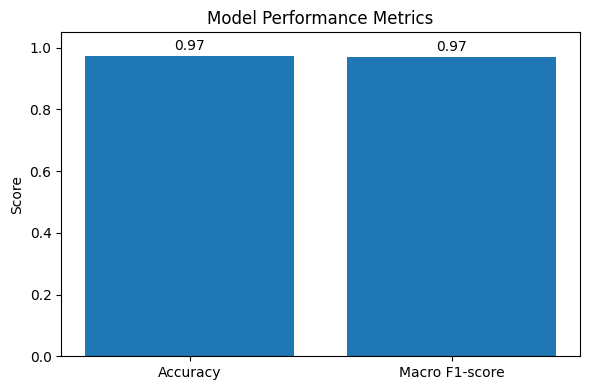

In [144]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Macro F1-score"]
values  = [acc, f1]   # acc and f1 are from your evaluation step

plt.figure(figsize=(6,4))
bars = plt.bar(metrics, values)

plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Model Performance Metrics")

# Show values on bars
for bar in bars:
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y + 0.01,
             f"{y:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


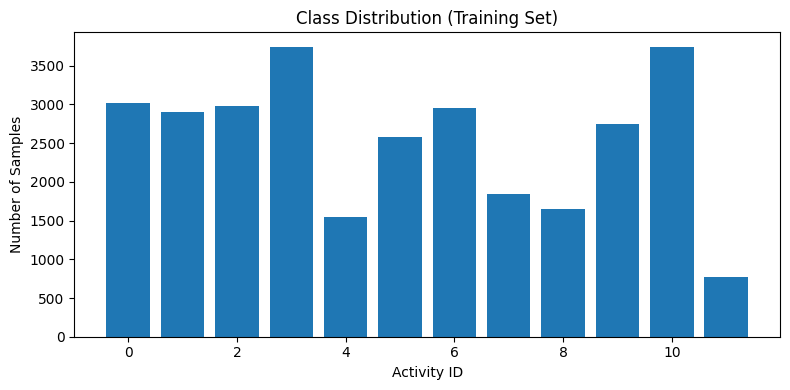

In [149]:
from collections import Counter
import matplotlib.pyplot as plt

class_counts = Counter(y_train)

plt.figure(figsize=(8,4))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Activity ID")
plt.ylabel("Number of Samples")
plt.title("Class Distribution (Training Set)")
plt.tight_layout()
plt.show()


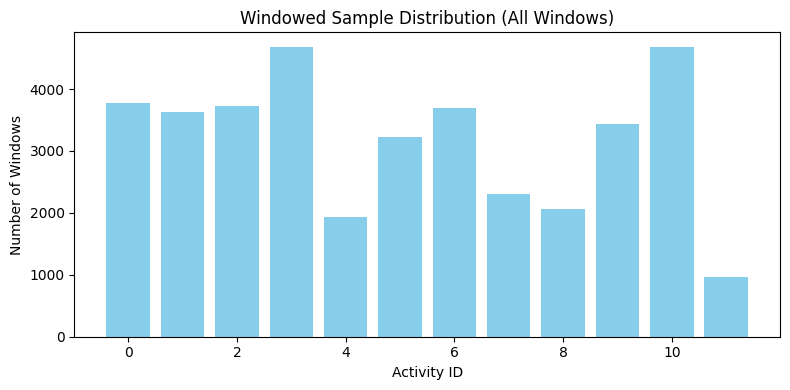

In [59]:
window_counts = Counter(y)  # y contains the labels for all windows

plt.figure(figsize=(8,4))
plt.bar(window_counts.keys(), window_counts.values(), color='skyblue')
plt.xlabel("Activity ID")
plt.ylabel("Number of Windows")
plt.title("Windowed Sample Distribution (All Windows)")
plt.tight_layout()
plt.show()

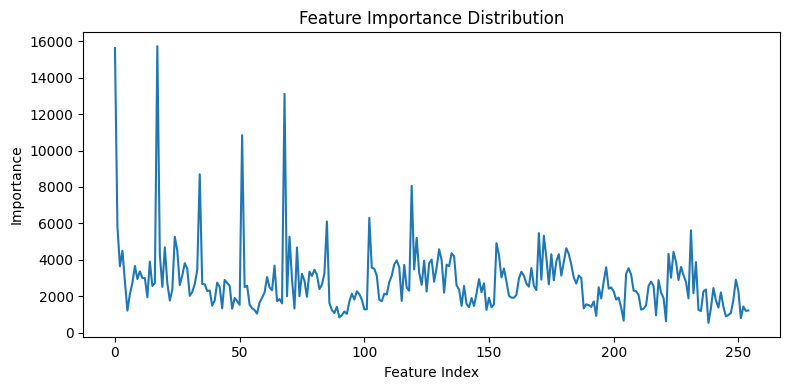

In [147]:
importances = model.feature_importances_

plt.figure(figsize=(8,4))
plt.plot(importances)
plt.title("Feature Importance Distribution")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [154]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout

inp = Input(shape=(X.shape[1], X.shape[2]))

x = Conv1D(64, 5, activation="relu")(inp)
x = MaxPooling1D(2)(x)

x = Conv1D(128, 5, activation="relu")(x)
x = MaxPooling1D(2)(x)

x = LSTM(64)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)

feature_output = Dense(64, activation="linear")(x)

feature_model = Model(inp, feature_output)
feature_model.compile(optimizer="adam", loss="mse")


In [157]:
def batch_predict(model, X, batch_size=64):
    outputs = []
    for i in range(0, len(X), batch_size):
        batch = X[i:i+batch_size]
        out = model.predict(batch, verbose=0)
        outputs.append(out)
    return np.vstack(outputs)


In [158]:
X_deep = batch_predict(feature_model, X, batch_size=32)
print(X_deep.shape)


(38091, 64)


In [162]:
data["label"] = le.fit_transform(data["activity_id"])


In [163]:
y_labels = data["label"].values


In [166]:
y_window = y   # for clarity


In [170]:
def create_windows(df, window=256, overlap=0.8):
    step = int(window * (1 - overlap))
    X, y = [], []

    values = df[FEATURES].values
    labels = df["label"].values

    for i in range(0, len(df) - window, step):
        X.append(values[i:i+window])
        y.append(np.bincount(labels[i:i+window]).argmax())

    return np.array(X), np.array(y)


In [171]:
X, y_window = create_windows(data)

print(type(y_window))
print(y_window.shape)
print(np.unique(y_window))


<class 'numpy.ndarray'>
(38091,)
[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [177]:
print("X_feat shape :", X_feat.shape)    # handcrafted
print("X_deep shape :", X_deep.shape)    # deep
print("y_window shape:", y_window.shape)

assert X_feat.shape[0] == X_deep.shape[0] == y_window.shape[0]


X_feat shape : (38091, 255)
X_deep shape : (38091, 64)
y_window shape: (38091,)


In [178]:
# Concatenate handcrafted + deep features
X_hybrid = np.hstack([X_feat, X_deep])

print("Hybrid feature shape:", X_hybrid.shape)


Hybrid feature shape: (38091, 319)


In [179]:
from sklearn.model_selection import train_test_split

X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_hybrid,
    y_window,
    test_size=0.2,
    stratify=y_window,
    random_state=42
)


In [180]:
from sklearn.utils.class_weight import compute_class_weight

weights_h = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_h),
    y=y_train_h
)

class_weight_h = dict(enumerate(weights_h))


In [181]:
import lightgbm as lgb

hybrid_model = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=NUM_CLASSES,
    n_estimators=1200,
    learning_rate=0.03,
    num_leaves=256,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.95,
    colsample_bytree=0.95,
    class_weight=class_weight_h,
    random_state=42,
    n_jobs=-1
)

hybrid_model.fit(X_train_h, y_train_h)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80470
[LightGBM] [Info] Number of data points in the train set: 30472, number of used features: 319
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Info] Start training from score -2.484907
[LightGBM] [Warning] No further splits with positive gain, be

,boosting_type,'gbdt'
,num_leaves,256
,max_depth,-1
,learning_rate,0.03
,n_estimators,1200
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,"{0: np.float64(0.8411173677818262), 1: np.float64(0.8747272936043173), 2: np.float64(0.8521252796420582), 3: np.float64(0.6780596350689808), ...}"
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [182]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

y_pred_h = hybrid_model.predict(X_test_h)

acc_h = accuracy_score(y_test_h, y_pred_h)
f1_h  = f1_score(y_test_h, y_pred_h, average="macro")

print("HYBRID Accuracy :", acc_h)
print("HYBRID Macro F1 :", f1_h)

print("\nHybrid Classification Report:\n")
print(classification_report(y_test_h, y_pred_h))


F:\chudling pong\envs\ai_project\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


HYBRID Accuracy : 0.9733560834755217
HYBRID Macro F1 : 0.9708117868090563

Hybrid Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       755
           1       1.00      0.99      1.00       726
           2       0.99      0.99      0.99       745
           3       0.85      0.99      0.92       936
           4       0.99      0.80      0.89       385
           5       1.00      1.00      1.00       646
           6       0.99      0.92      0.95       738
           7       0.99      0.99      0.99       460
           8       0.99      0.99      0.99       411
           9       0.99      0.99      0.99       688
          10       1.00      0.99      0.99       936
          11       0.99      0.91      0.95       193

    accuracy                           0.97      7619
   macro avg       0.98      0.96      0.97      7619
weighted avg       0.98      0.97      0.97      7619



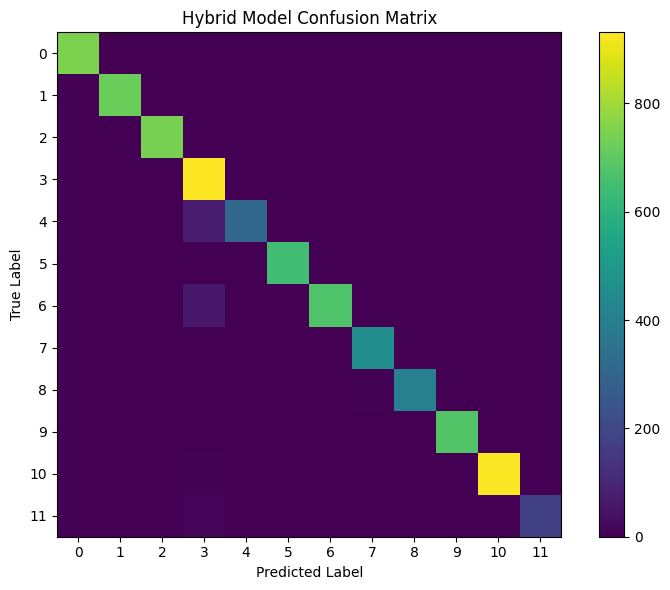

In [183]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test_h, y_pred_h)

plt.figure(figsize=(8,6))
plt.imshow(cm)
plt.title("Hybrid Model Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()

plt.xticks(np.arange(NUM_CLASSES))
plt.yticks(np.arange(NUM_CLASSES))

plt.tight_layout()
plt.show()


In [189]:
import numpy as np
import matplotlib.pyplot as plt

models = ["LightGBM", "Hybrid"]

accuracy_pct = [acc * 100, acc_h * 100]
f1_pct = [f1 * 100, f1_h * 100]


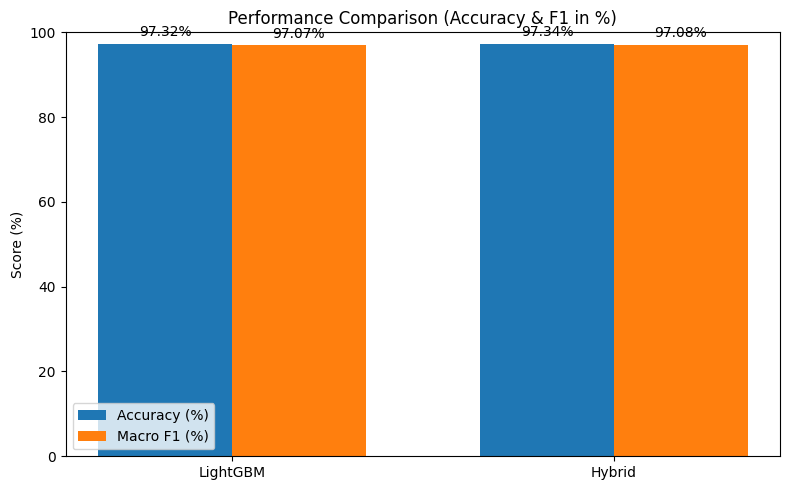

In [190]:
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,5))

bars1 = plt.bar(x - width/2, accuracy_pct, width, label="Accuracy (%)")
bars2 = plt.bar(x + width/2, f1_pct, width, label="Macro F1 (%)")

plt.xticks(x, models)
plt.ylabel("Score (%)")
plt.ylim(0, 100)
plt.title("Performance Comparison (Accuracy & F1 in %)")
plt.legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height + 1,
            f"{height:.2f}%",
            ha="center",
            va="bottom",
            fontsize=10
        )

plt.tight_layout()
plt.show()


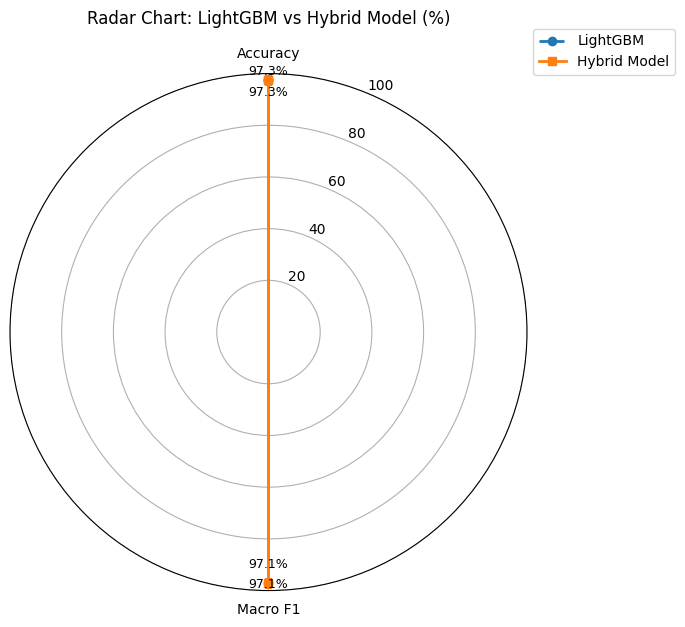

In [191]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics
labels = ["Accuracy", "Macro F1"]
lightgbm_scores = [acc * 100, f1 * 100]
hybrid_scores   = [acc_h * 100, f1_h * 100]

# Close the radar shape
lightgbm_scores += lightgbm_scores[:1]
hybrid_scores   += hybrid_scores[:1]

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)

# Rotate so first axis is at the top
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Axis labels
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 100)

# LightGBM
ax.plot(
    angles,
    lightgbm_scores,
    linewidth=2,
    linestyle="--",
    marker="o",
    label="LightGBM"
)
ax.fill(
    angles,
    lightgbm_scores,
    alpha=0.15
)

# Hybrid
ax.plot(
    angles,
    hybrid_scores,
    linewidth=2,
    linestyle="-",
    marker="s",
    label="Hybrid Model"
)
ax.fill(
    angles,
    hybrid_scores,
    alpha=0.15
)

# Value annotations
for angle, score in zip(angles[:-1], lightgbm_scores[:-1]):
    ax.text(angle, score + 2, f"{score:.1f}%", fontsize=9, ha="center")

for angle, score in zip(angles[:-1], hybrid_scores[:-1]):
    ax.text(angle, score - 6, f"{score:.1f}%", fontsize=9, ha="center")

plt.title("Radar Chart: LightGBM vs Hybrid Model (%)", y=1.08)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()
